# Finding corresponding GALEX data for Kepler flares

We crossmatched our GALAX data against two catalogs: 
[Balona 2015](https://ui.adsabs.harvard.edu/abs/2015MNRAS.447.2714B/abstract) (short cadence), and
[Yang and Liu 2019](https://ui.adsabs.harvard.edu/abs/2019ApJS..241...29Y/abstract) (long cadence)

Only the long cadence catalog had flares that overlapped with GALEX data, and the overlap was only 7 light curves.
We also cross-matched the Yang catalog flaring stars with our GALEX flaring stars and found 12 stars showing flares in both GALEX and Kepler data (but not simultaneous data).

- [Kepler Flares with GALEX data](#Kepler-Flares-with-GALEX-data)

In [1]:
import sys

import numpy as np

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt

from astropy.table import Table, Column#, vstack, join# unique, MaskedColumn
from astropy import units as u
from astropy.time import Time

from scipy.stats import kstest

import arhap

sys.path.append('../src')

import findflares

## Kepler Flares with GALEX data

### Table cross-match

This table is the cross-match between the [Yang and Liu](https://ui.adsabs.harvard.edu/abs/2019ApJS..241...29Y/abstract) targets and the complete GALEX target list (i.e. not just the ones Brasseur et al 2019 found flares on).

We added 6 columns to the original table:
- **E_yang:** The catalog lists log(energy) this is just turning it into energy on its own. 
- **E_kep:** The energy presented by Yang and Liu is the full blackbody energy for the flare, this column lists only the Kepler-band energy.
- **E_bol:** This column uses the energy fractionation from Table 2 of [Osten and Wolk 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...809...79O/abstract) to calculate the putative bolometric flux of the flare.
- **GID:** The star's GALEX ID
- **galex_interval_start:** The start of the GALEX visit overlapping the flare
- **galex_interval_end:** The end of the GALEX visit overlapping the flare

In [2]:
yang_lc_cat = Table.read("../data_tables/yang_lc_flare_catalog.ecsv", format="ascii.ecsv")

In [3]:
yang_kids = np.unique(yang_lc_cat[yang_lc_cat["galex_interval_start"] != Time(0, format='jd')]["KIC"])
print(f"Number of flaring stars with GALEX overlaps found: {len(yang_kids)}")

Number of flaring stars with GALEX overlaps found: 7


### Comparing flaring and non-flaring galex intervals

**Note:** The warnings can be ignored, they are the result of nul values in columns we don't use in the galex light curves.

In [5]:
interval_stats = {"KID":[], "flare_fluxs":[], "nonflare_fluxs":[], "gdat_fltime":[]}

for kid in yang_kids:

    interval_stats["KID"].append(kid)

    kepler_flares = yang_lc_cat[yang_lc_cat["KIC"] == kid]
    
    # Manually picking out the first row because there is only ever one row (checked ahead of time)
    flare_row = kepler_flares[kepler_flares["galex_interval_start"] != Time(0,format='jd')][0]

    galex_lc = Table.read(f"../light_curves/galex/{flare_row['GID']}_LC.csv")
    galex_lc = galex_lc[galex_lc['counts'] < 1000000] # for new files
    galex_lc = galex_lc[galex_lc['counts'] >= 1] # for new files
    galex_lc["time"] = arhap.galex_to_time(galex_lc["t_mean"])
    
    flare_inds = np.full(len(galex_lc), False, dtype=bool)
    flare_inds |= ((galex_lc["time"] > flare_row["galex_interval_start"]) & 
                   (galex_lc["time"] < flare_row["galex_interval_end"]))
        
    flare_times = galex_lc[flare_inds]
    interval_stats["flare_fluxs"].append(flare_times["flux"])
    
    nonfl_times = galex_lc[~flare_inds]
    interval_stats["nonflare_fluxs"].append(nonfl_times["flux"])
    
    g_time = flare_times["exptime"].sum()*u.s
    fl_len = (flare_row["end_time"] - flare_row["start_time"]).to(u.s)
    interval_stats["gdat_fltime"].append((g_time/fl_len).value)
    
    
flux_table = Table(interval_stats)

Performing a k-s test and looking at the mean/median ratios

In [6]:
flux_table.add_column(Column(name="ks_stat", dtype=float, length=len(flux_table)))
flux_table.add_column(Column(name="pval", dtype=float, length=len(flux_table)))
flux_table.add_column(Column(name="med_ratio", dtype=float, length=len(flux_table)))
flux_table.add_column(Column(name="mean_ratio", dtype=float, length=len(flux_table)))

In [7]:
for row in flux_table:
    res = kstest(row['flare_fluxs'], row['nonflare_fluxs'])
    row['ks_stat'] = res.statistic
    row['pval'] = res.pvalue
    
    row['med_ratio'] = np.median(row['flare_fluxs'])/np.median(row['nonflare_fluxs'])
    row['mean_ratio'] = np.mean(row['flare_fluxs'])/np.mean(row['nonflare_fluxs'])

In [8]:
flux_table["KID",'ks_stat', 'pval', 'med_ratio', 'mean_ratio', 'gdat_fltime']

KID,ks_stat,pval,med_ratio,mean_ratio,gdat_fltime
int32,float64,float64,float64,float64,float64
3852116,0.18518518518518517,0.35328049715805987,1.073468153467382,1.1004029397237962,0.16608573373255844
6507888,0.9154418435855561,1.8257128302053443e-30,4.691185254946594,4.573127869589617,0.06198766193878135
7049035,0.12190130384551906,0.2436474793068294,1.062336609237362,1.077373387411432,0.13680205997132083
7434110,0.30580479765610696,0.0035355252166462403,1.1521874779696426,1.134023949543221,0.16995416361976332
9268249,0.24602943896831478,0.0004209674623023574,1.146466112682826,1.1181441772616345,0.10869664865126627
11662738,0.18859903381642512,0.3694192293983424,1.0830811654243642,1.0095087312220872,0.008700245635835697
11872364,0.4459031373743527,3.8191672047105385e-14,1.339306626052038,1.2883431546839588,0.12532509116758137


Looking at the flaring vs non-flaring histograms of the ones without a low p-val (note the 1.8e-30 in the second row).

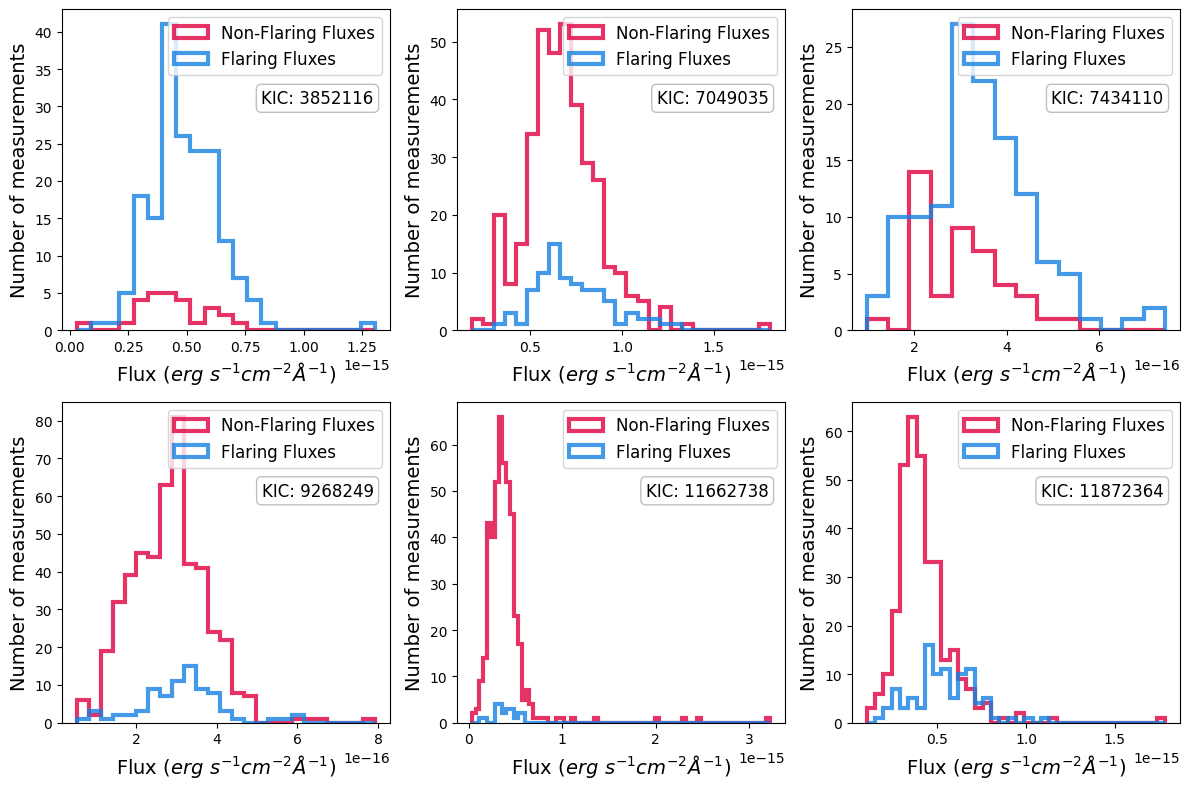

In [11]:
f, axs = plt.subplots(figsize=(12, 8), nrows=2, ncols=3)

tbl_ind = -1
for row in flux_table:
    
    if row["pval"] < 1e-25: #Skip the outlier
        continue
        
    tbl_ind += 1
    
    ax = axs.flatten()[tbl_ind]
    
    ax.hist([row['flare_fluxs'], row['nonflare_fluxs']], histtype='step', bins='auto',
            alpha=0.8, color=['#1581e1', '#df0040'],lw=3,label=["Flaring Fluxes","Non-Flaring Fluxes"])
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.25)
    ax.text(0.95, 0.75, f"KIC: {row['KID']}", fontsize=12,
            transform=ax.transAxes, verticalalignment='top', ha="right", bbox=props)
    
    
    
    ax.legend(fontsize=12)
             
    ax.set_xlabel("Flux ($erg~s^{-1} cm^{-2} \AA^{-1}$)", fontsize=14)
    ax.set_ylabel("Number of measurements", fontsize=14)

    
plt.tight_layout()

#f.savefig("../plots/kepler_flare_histograms.pdf")

plt.show()

### Looking at the one outlier

In [70]:
kid = row["KID"]
flare_row = yang_lc_cat[(yang_lc_cat["KIC"] == kid) & (yang_lc_cat["galex_interval_start"] != Time(0,format='jd'))][0]

kepler_lc = Table.read(f"../light_curves/kepler_lc/kepler_{kid}_lc.ecsv", format="ascii.ecsv")
kepler_lc = kepler_lc[~kepler_lc['flux'].mask]

galex_lc = Table.read(f"../light_curves/galex/{flare_row['GID']}_LC.csv") # ignore warnings, they are nuls in columns we don't use
galex_lc["time"] = arhap.galex_to_time(galex_lc["t_mean"])

/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


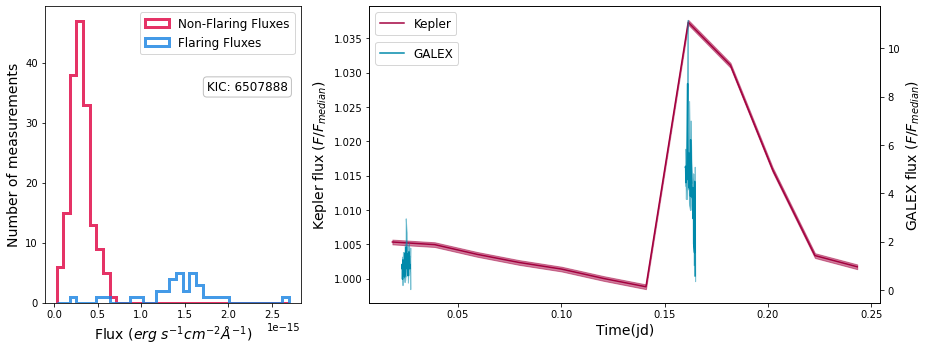

In [109]:
f, axs = plt.subplots(figsize=(13, 5), nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 2]})

row = flux_table[flux_table["pval"] < 1e-25][0]

# plotting the histogram
ax = axs[0] 
ax.hist([row['flare_fluxs'], row['nonflare_fluxs']], histtype='step', bins='auto',
        alpha=0.8, color=['#1581e1', '#df0040'],lw=3,label=["Flaring Fluxes","Non-Flaring Fluxes"])
    
props = dict(boxstyle='round', facecolor='white', alpha=0.25)
ax.text(0.95, 0.75, f"KIC: {row['KID']}", fontsize=12,
        transform=ax.transAxes, verticalalignment='top', ha="right", bbox=props)
    
ax.legend(fontsize=12)
ax.set_xlabel("Flux ($erg~s^{-1} cm^{-2} \AA^{-1}$)", fontsize=14)
ax.set_ylabel("Number of measurements", fontsize=14)

# Plotting the light curves
ax = axs[1] 

st = flare_row["galex_interval_start"]-.16
et = flare_row["galex_interval_start"]+.1

# Kepler
k_inds = (kepler_lc['time'] > st) & (kepler_lc['time'] < et)
k_med = np.median(kepler_lc['flux']) # causes warning about ignoring the mask which is fine, we've already removed the masked values
ax.plot(kepler_lc['time'][k_inds].jd-st.jd, kepler_lc['flux'][k_inds]/k_med, color="#a3003e", label="Kepler")
ax.fill_between(kepler_lc['time'][k_inds].jd-st.jd, 
                (kepler_lc['flux'] - kepler_lc['flux_err'])[k_inds]/k_med, 
                (kepler_lc['flux'] + kepler_lc['flux_err'])[k_inds]/k_med,
                color="#a3003e", alpha=0.5)

# GALEX
ax2 = ax.twinx()
g_inds = (galex_lc['time'] > st) & (galex_lc['time'] < et)
g_med = np.median(galex_lc['flux'])

# This spans 2 GALEX intervals, so we want to plot them seperately
break_ind = np.where((galex_lc['time'][g_inds][1:] - galex_lc['time'][g_inds][:-1])>20*u.min)[0][0]+1
ax2.plot(galex_lc['time'][g_inds].jd[:break_ind]-st.jd, 
         galex_lc['flux'][g_inds][:break_ind]/g_med, color="#0089aa", label="GALEX")
ax2.fill_between(galex_lc['time'][g_inds].jd[:break_ind]-st.jd, 
                 (galex_lc['flux'] - galex_lc['flux_err'])[g_inds][:break_ind]/g_med, 
                 (galex_lc['flux'] + galex_lc['flux_err'])[g_inds][:break_ind]/g_med,
                 color="#0089aa", alpha=0.5)

ax2.plot(galex_lc['time'][g_inds].jd[break_ind:]-st.jd, 
         galex_lc['flux'][g_inds][break_ind:]/g_med, color="#0089aa")
ax2.fill_between(galex_lc['time'][g_inds].jd[break_ind:]-st.jd, 
                 (galex_lc['flux'] - galex_lc['flux_err'])[g_inds][break_ind:]/g_med, 
                 (galex_lc['flux'] + galex_lc['flux_err'])[g_inds][break_ind:]/g_med,
                 color="#0089aa", alpha=0.5)

ax.legend(fontsize=12, loc='upper left')
ax2.legend(fontsize=12, loc='upper left', bbox_to_anchor=(0, 0.9))
ax.set_xlabel("Time(jd)", fontsize=14)
ax.set_ylabel("Kepler flux ($F/F_{median}$)", fontsize=14)
ax2.set_ylabel("GALEX flux ($F/F_{median}$)", fontsize=14)

plt.tight_layout()

f.savefig("../plots/outlier_overlap_flare.pdf")

plt.show()